In [1]:
import os
from pathlib import Path

# 方法 1：相對於 notebook 位置
notebook_dir = Path.cwd()
project_root = notebook_dir.parent.parent  # 從 model/aapl 往上兩層
os.chdir(project_root)

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import numpy as np
import ta

In [3]:
df = pd.read_csv("data/2330_TW.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[23:]
df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
stoch = ta.momentum.StochasticOscillator(df['High'], df['Low'], df['Close'], window=14)
df['k'] = stoch.stoch()
df['d'] = stoch.stoch_signal()
df

,Close,High,Low,Open,Volume,rsi,k,d
Date,,,,,,,,
2014-01-03,73.997704,74.358668,73.636739,74.358668,38599000,NaN,NaN,NaN
2014-01-06,73.997704,74.358668,73.636739,73.636739,23706000,NaN,NaN,NaN
2014-01-07,73.636726,74.358655,73.636726,73.997691,15836000,NaN,NaN,NaN
2014-01-08,75.080612,75.441577,73.997719,74.358683,30218000,NaN,NaN,NaN
2014-01-09,72.914787,74.358644,72.553823,73.997680,63998000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-12-25,564.011108,567.894145,563.040349,564.981868,9548143,58.299930,71.936110,67.926818
2023-12-26,568.864929,568.864929,564.981892,565.952651,16094308,62.416420,91.982151,79.954442
2023-12-27,574.689453,574.689453,568.864898,569.835657,33401336,66.668544,100.000000,87.972754


In [4]:
from sklearn.preprocessing import MinMaxScaler

def preprocess(data_trend, train_ratio, n_past, predict_day):
    scaler = MinMaxScaler()  
    print(data_trend.shape)
    data_trend = scaler.fit_transform(data_trend)
    
    train_ind = int(len(data_trend) * train_ratio)
    train_data = data_trend[:train_ind]
    test_data = data_trend[train_ind:]

    # 產生序列資料
    X_train_full, Y_train_full = create_sequences(train_data, n_past, predict_day)
    X_test, Y_test = create_sequences(test_data, n_past, predict_day)

    val_ind = int(len(X_train_full) * test_val_ratio)
    X_train, X_val = X_train_full[:val_ind], X_train_full[val_ind:]
    Y_train, Y_val = Y_train_full[:val_ind], Y_train_full[val_ind:]

    return X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler



def create_sequences(data, n_past, predict_day):
    X, Y = [], []
    L = len(data)
    for i in range(L - (n_past + predict_day - 1)):
        X.append(data[i:i + n_past])  # 過去 n_past 天的資料
        Y.append(data[i + n_past:i + n_past + predict_day])  # 預測未來 predict_day 天的目標變數
    return torch.Tensor(np.array(X)), torch.Tensor(np.array(Y))

data = df[[c for c in df.columns if c not in ['Date','Adj Close','Volume','rsi','k','d']]].values
train_ratio = 0.9
test_val_ratio = 0.9
n_past = 40     #移動視窗大小
predict_day = 5 #要預測後面幾天
X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler = preprocess(data, train_ratio, n_past, predict_day)
batch_size = 32

print(Y_train.shape)
train_set = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False)

val_set = torch.utils.data.TensorDataset(X_val, Y_val)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

test_set = torch.utils.data.TensorDataset(X_test, Y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

(2439, 4)
torch.Size([1935, 5, 4])


In [5]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size=36, hidden_size=128, n_layers=1, dropout=0.3):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, n_layers)
        
    def forward(self, x):
        # x: input batch data, size: [input_seq_len, batch_size, feature_size]
        output, (hidden, cell) = self.lstm(x)
        return hidden, cell


class Decoder(nn.Module):
    def __init__(self, output_size, embedding_size=36, hidden_size=128, n_layers=1, dropout=0.3):
        super().__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.lstm = nn.LSTM(output_size, hidden_size, n_layers)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell):
        """
        x size = [batch_size, feature_size]
        --> x only has two dimensions since the input is batch of last coordinate of observed trajectory
        so the sequence length has been removed.
        """
        # add sequence dimension to x, to allow use of nn.LSTM
        x = x.unsqueeze(0)  # -->[1, batch_size, feature_size]
        
        output, (hidden, cell) = self.lstm(x, (hidden, cell))
        prediction = self.linear(output)

        return prediction, hidden, cell    

In [6]:
import random

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert encoder.hidden_size == decoder.hidden_size, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, x, y, teacher_forcing_ratio=0.5):
        x = x.permute(1,0,2) #我們的 dataloader是 [batch, seq,dim]
        y = y.permute(1,0,2) #但為了方便操作LSTM，直接把它擺成[seq,batch,dim]，output再把它擺回來
        """
        x = [input_seq_len, batch_size, feature_size]
        y = [target_seq_len, batch_size, feature_size]
        """
        batch_size = x.shape[1]
        target_len = y.shape[0]
        
        # tensor to store decoder outputs of each time step
        outputs = torch.zeros(y.shape).to(self.device) 
        
        hidden, cell = self.encoder(x)
        decoder_input = x[-1, :, :] # first input to decoder is last of x
        
        for i in range(target_len):
            output, hidden, cell = self.decoder(decoder_input, hidden, cell)
            # place predictions in a tensor holding predictions for each time step
            outputs[i] = torch.squeeze(output,0)
            
            teacher_forcing = random.random() < teacher_forcing_ratio
            # output is the same shape as decorder input-->[batch_size, feature_size]
            # so we use output directly as input or use true lable depending on teacher_forcing flag
            decoder_input = y[i] if teacher_forcing else torch.squeeze(output,0)
        
        return outputs.permute(1,0,2)

In [7]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
# 檢查是否有可用的GPU
if torch.cuda.is_available():
    print("GPU")
    device = torch.device("cuda")  # 使用GPU
else:
    print("CPU")
    device = torch.device("cpu")  # 使用CPU
# 設置訓練參數
num_epochs = 100
learning_rate = 0.001

# 初始化模型、損失函數和優化器
encoder = Encoder(input_size=4, hidden_size=128).to(device)
decoder = Decoder(output_size=4, hidden_size=128).to(device)
model = Seq2Seq(encoder, decoder, device).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

GPU


In [8]:
# 記錄每個 epoch 的損失值
train_losses = []
val_losses = []
min_loss = 100
min_val_loss = float('inf')
best_model_path = "output/model/2330tw/seq_lstm_5.pth"

# 訓練模型
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # print(f"x_batch shape: {x_batch.shape}, y_batch shape: {y_batch.shape}")
        x_batch= x_batch.to(device)
        y_batch= y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch, y_batch, teacher_forcing_ratio=0.5)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    # 驗證模型
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(test_loader):
            x_batch= x_batch.to(device)
            y_batch= y_batch.to(device)
            outputs = model(x_batch, y_batch, teacher_forcing_ratio=0.0)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

   # if val_loss < min_val_loss:
   #     min_val_loss = val_loss
   #     torch.save(model, best_model_path) 
   #     print(f"Model saved with val_loss: {val_loss:.4f}")
    # 打印每個epoch的訓練和驗證損失
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
torch.save(model, best_model_path)

Epoch [1/100], Train Loss: 0.0028, Val Loss: 0.0284
Epoch [2/100], Train Loss: 0.0650, Val Loss: 0.1336
Epoch [3/100], Train Loss: 0.0492, Val Loss: 0.0366
Epoch [4/100], Train Loss: 0.0103, Val Loss: 0.0257
Epoch [5/100], Train Loss: 0.0028, Val Loss: 0.0020
Epoch [6/100], Train Loss: 0.0006, Val Loss: 0.0006
Epoch [7/100], Train Loss: 0.0014, Val Loss: 0.0024
Epoch [8/100], Train Loss: 0.0016, Val Loss: 0.0069
Epoch [9/100], Train Loss: 0.0022, Val Loss: 0.0111
Epoch [10/100], Train Loss: 0.0019, Val Loss: 0.0008
Epoch [11/100], Train Loss: 0.0041, Val Loss: 0.0129
Epoch [12/100], Train Loss: 0.0027, Val Loss: 0.0013
Epoch [13/100], Train Loss: 0.0077, Val Loss: 0.0018
Epoch [14/100], Train Loss: 0.0108, Val Loss: 0.0062
Epoch [15/100], Train Loss: 0.0072, Val Loss: 0.0327
Epoch [16/100], Train Loss: 0.0034, Val Loss: 0.0322
Epoch [17/100], Train Loss: 0.0038, Val Loss: 0.0042
Epoch [18/100], Train Loss: 0.0063, Val Loss: 0.0006
Epoch [19/100], Train Loss: 0.0020, Val Loss: 0.0006
Ep

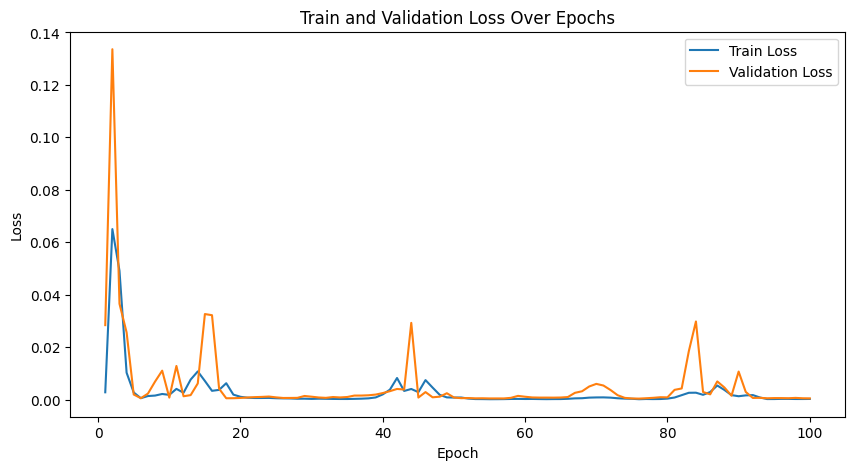

In [9]:
import matplotlib.pyplot as plt
# 繪製損失走勢圖
plt.figure(figsize=(10, 5))
plt.plot(range(1, 100+1), train_losses, label='Train Loss')
plt.plot(range(1, 100+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss Over Epochs')
plt.show()

C:\Users\N98141062\AppData\Local\Temp\ipykernel_9768\1837569954.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('output/model/2330tw/seq_lstm_5.pth')


MAE:  6.1925
RMSE: 8.1819
MAPE: 1.1689%
R²:   0.9030


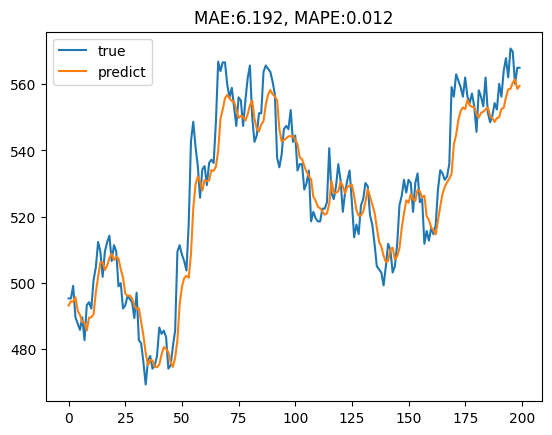

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
close_price_true = []
close_price_pred = []
model = torch.load('output/model/2330tw/seq_lstm_5.pth')
model.to(device)

dim = 3
for i in range(len(test_set)):
    x,y = test_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device), y.to(device), teacher_forcing_ratio=0)
    # print(pred)
    # print(scaler.inverse_transform(torch.squeeze(pred.detach().cpu())))
    y=torch.squeeze(y)
    # print(scaler.inverse_transform(y)[0,dim])
    close_price_true.append(scaler.inverse_transform(y)[0,dim])
    close_price_pred.append(scaler.inverse_transform(torch.squeeze(pred.detach().cpu()))[0,dim])

mape = np.mean(np.absolute(np.array(close_price_true) - np.array(close_price_pred))/np.array(close_price_true))
mae =  np.mean( np.absolute(np.array(close_price_true) - np.array(close_price_pred)))
# 新增：RMSE
rmse = np.sqrt(np.mean((np.array(close_price_true) - np.array(close_price_pred)) ** 2))
# 新增：R²
r2 = r2_score(close_price_true, close_price_pred)
plt.plot(close_price_true)
plt.plot(close_price_pred)
plt.title('MAE:{:.3f}, MAPE:{:.3f}'.format(mae, mape))
plt.legend(['true', 'predict'])
# 輸出所有指標
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4%}")
print(f"R²:   {r2:.4f}")

In [11]:
btdf = pd.DataFrame({'close':close_price_true, 'rsi':df['rsi'][-204:-4],'predicted_close':close_price_pred})

In [12]:
btdf =btdf.dropna().reset_index(drop=True)

In [13]:
btdf

,close,rsi,predicted_close
0,495.333975,54.665447,493.175204
1,495.333908,52.878740,494.491804
2,499.136932,53.425225,494.250386
3,489.629574,48.027092,495.698053
4,487.728063,49.846199,491.600438
...,...,...,...
195,570.806306,65.586338,558.629493
196,569.835555,65.586338,560.503594
197,560.128048,55.190730,561.446900
198,564.981801,59.510359,558.613350


買入價格: 487.7280626899514
賣出價格: 482.7198323695661
cash: 989733.1278432102
額外要扣掉: 4319.96939894139
扣掉後的: 985413.1584442689
-------------------------------------
買入價格: 493.2344993910272
賣出價格: 494.1903843262602
cash: 987322.0606599291
額外要扣掉: 4292.130778213375
扣掉後的: 983029.9298817157
-------------------------------------
買入價格: 509.4845096569368
賣出價格: 512.3521644626356
cash: 988561.6360019088
額外要扣掉: 4292.360435387029
扣掉後的: 984269.2755665218
-------------------------------------
買入價格: 511.39621226130123
賣出價格: 509.4844423908353
cash: 980591.0303357453
額外要扣掉: 4270.812481414348
扣掉後的: 976320.217854331
-------------------------------------
買入價格: 499.92572757070866
賣出價格: 489.4109596500954
cash: 955795.3908732939
額外要扣掉: 4186.957828746807
扣掉後的: 951608.4330445471
-------------------------------------
買入價格: 497.0580054989083
賣出價格: 482.7197651034646
cash: 924165.0409276679
額外要扣掉: 4059.2247618019082
扣掉後的: 920105.816165866
-------------------------------------
買入價格: 481.76388016823165
賣出價格: 474.11686795246

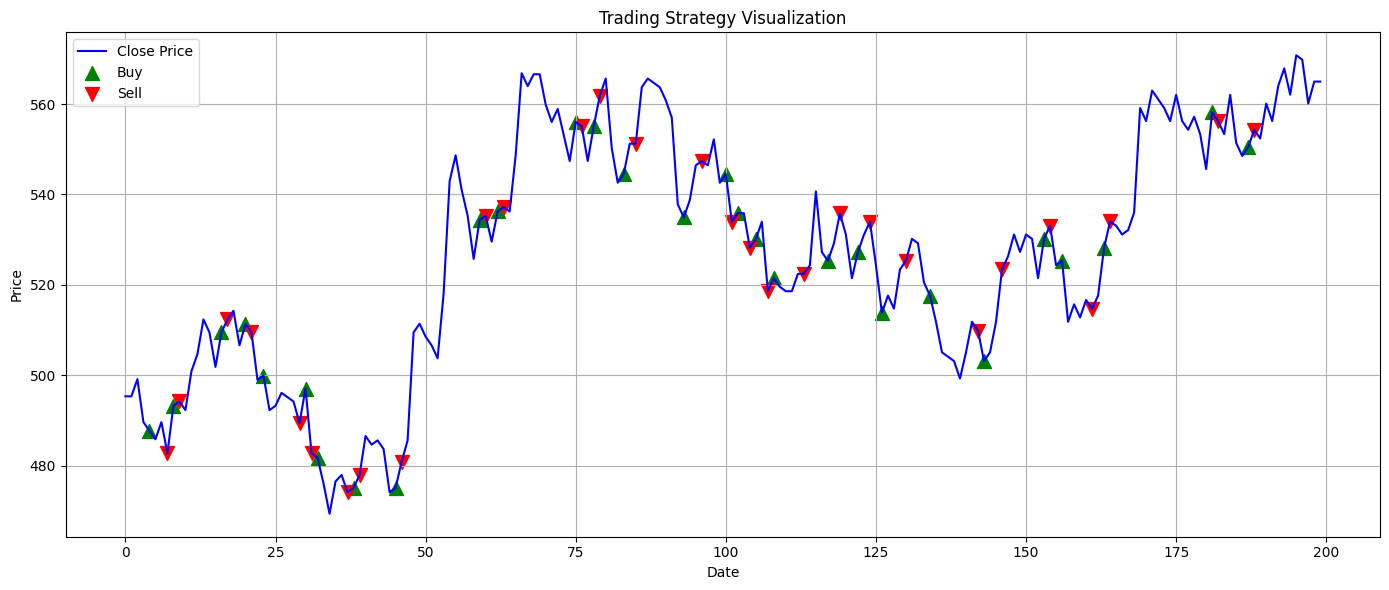

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# 初始化參數
initial_cash = 1000000
in_position = False
entry_price = 0
shares = 0
cash = initial_cash

# 儲存交易點資訊
buy_dates = []
buy_prices = []
sell_dates = []
sell_prices = []

# 手續費和稅率
fee_rate = 0.001425  # 手續費率 (1.425‰)
tax_rate = 0.0015     # 證券交易稅率 (1‰)
need_pay = 0 #需要付的手續費+稅金

# 模擬交易
for i in range(1, len(btdf)):
    if not in_position:
        need_pay = 0
        if btdf.loc[i, 'predicted_close'] > btdf.loc[i - 1, 'close']:
            entry_price = btdf.loc[i, 'close']
            shares = cash // entry_price
            need_pay += cash * fee_rate
            cash -= shares * entry_price
            in_position = True

            buy_dates.append(btdf.index[i])
            buy_prices.append(entry_price)

            print('買入價格:', entry_price)

    else:
        if btdf.loc[i, 'predicted_close'] < btdf.loc[i - 1, 'close']:
            exit_price = btdf.loc[i, 'close']
            cash += shares * exit_price
            need_pay += cash * (fee_rate + tax_rate)
            shares = 0
            in_position = False

            sell_dates.append(btdf.index[i])
            sell_prices.append(exit_price)

            print('賣出價格:', exit_price)
            print('cash:', cash)
            print('額外要扣掉:', need_pay)
            cash -= need_pay
            print('扣掉後的:', cash)
            print('-------------------------------------')

# 最後一天強制平倉
if in_position:
    final_price = btdf.loc[len(btdf) - 1, 'close']
    cash += shares * final_price
    sell_dates.append(btdf.index[-1])
    sell_prices.append(final_price)
    print('賣出價格:', final_price)

# 顯示最終資金
print('最終價格:', cash)

# 繪圖
plt.figure(figsize=(14, 6))
plt.plot(btdf.index, btdf['close'], label='Close Price', color='blue')

# 標記買進與賣出點
plt.scatter(buy_dates, buy_prices, color='green', label='Buy', marker='^', s=100)
plt.scatter(sell_dates, sell_prices, color='red', label='Sell', marker='v', s=100)

plt.title('Trading Strategy Visualization')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


買入價格: 487.7280626899514
賣出價格: 548.6755229370822
cash: 1124942.2935066181
額外要扣掉: 4715.456208506858
扣掉後的: 1120226.8372981113
-------------------------------------
買入價格: 534.3373834407907
賣出價格: 564.9818685629901
最終價格: 1184457.6781142412


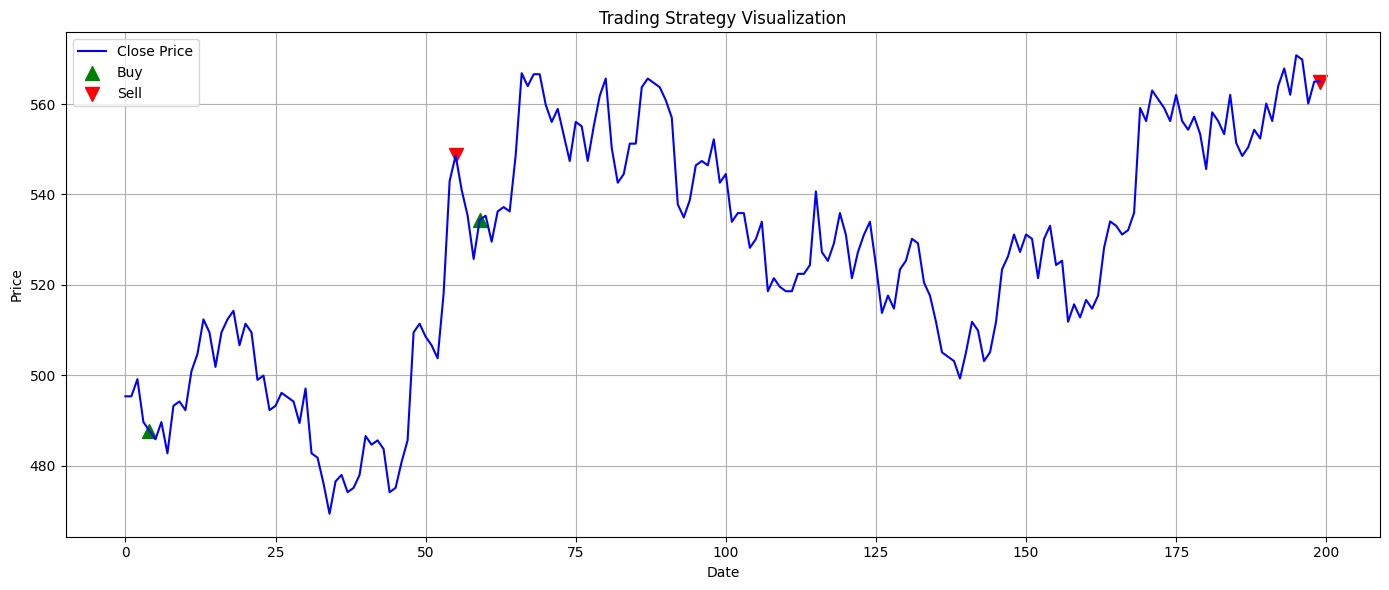

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# 初始化參數
initial_cash = 1000000
in_position = False
entry_price = 0
shares = 0
cash = initial_cash

# 儲存交易點資訊
buy_dates = []
buy_prices = []
sell_dates = []
sell_prices = []

# 手續費和稅率
fee_rate = 0.001425  # 手續費率 (1.425‰)
tax_rate = 0.0015     # 證券交易稅率 (1.5‰)
need_pay = 0 #需要付的手續費+稅金

# 模擬交易
for i in range(1, len(btdf)):
    if not in_position:
        need_pay = 0
        if btdf.loc[i, 'predicted_close'] > btdf.loc[i - 1, 'close']:
            entry_price = btdf.loc[i, 'close']
            shares = cash // entry_price
            need_pay += cash * fee_rate
            cash -= shares * entry_price
            in_position = True

            buy_dates.append(btdf.index[i])
            buy_prices.append(entry_price)

            print('買入價格:', entry_price)

    else:
        if btdf.loc[i, 'rsi'] > 75.704 and btdf.loc[i, 'predicted_close'] < btdf.loc[i - 1, 'close']:
            exit_price = btdf.loc[i, 'close']
            cash += shares * exit_price
            need_pay += cash * (fee_rate + tax_rate)
            shares = 0
            in_position = False

            sell_dates.append(btdf.index[i])
            sell_prices.append(exit_price)

            print('賣出價格:', exit_price)
            print('cash:', cash)
            print('額外要扣掉:', need_pay)
            cash -= need_pay
            print('扣掉後的:', cash)
            print('-------------------------------------')

# 最後一天強制平倉
if in_position:
    final_price = btdf.loc[len(btdf) - 1, 'close']
    cash += shares * final_price
    sell_dates.append(btdf.index[-1])
    sell_prices.append(final_price)
    print('賣出價格:', final_price)

# 顯示最終資金
print('最終價格:', cash)

# 繪圖
plt.figure(figsize=(14, 6))
plt.plot(btdf.index, btdf['close'], label='Close Price', color='blue')

# 標記買進與賣出點
plt.scatter(buy_dates, buy_prices, color='green', label='Buy', marker='^', s=100)
plt.scatter(sell_dates, sell_prices, color='red', label='Sell', marker='v', s=100)

plt.title('Trading Strategy Visualization')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
close_price_true = []
close_price_pred = []

dim = 3
for i in range(len(test_set)):
    x,y = test_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device), y.to(device), teacher_forcing_ratio=0)
    # print(pred)
    # print(scaler.inverse_transform(torch.squeeze(pred.detach().cpu())))
    y=torch.squeeze(y)
    # print(scaler.inverse_transform(y)[:,dim])
    close_price_true.append(scaler.inverse_transform(y)[:,dim])
    close_price_pred.append(scaler.inverse_transform(torch.squeeze(pred.detach().cpu()))[:,dim])

print(np.array(close_price_true).shape)
print(np.array(close_price_pred).shape)
mape = np.mean(np.absolute(np.array(close_price_true) - np.array(close_price_pred))/np.array(close_price_true))
mae =  np.mean( np.absolute(np.array(close_price_true) - np.array(close_price_pred)))
# 新增：RMSE
rmse = np.sqrt(np.mean((np.array(close_price_true) - np.array(close_price_pred)) ** 2))
# 新增：R²
r2 = r2_score(close_price_true, close_price_pred)
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4%}")
print(f"R²:   {r2:.4f}")

(200, 5)
(200, 5)
MAE:  10.0016
RMSE: 13.0327
MAPE: 1.8933%
R²:   0.7575


In [17]:
close_price_true = []
close_price_pred = []

dim = 3
for i in range(len(test_set)):
    x, y = test_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device), y.to(device), teacher_forcing_ratio=0)
    
    # 取第十天的真實值和預測值
    y_tenth_day = torch.squeeze(y)[4]  # 第 5 天對應索引為 4
    pred_tenth_day = torch.squeeze(pred.detach().cpu())[4]
    
    # 反轉換
    true_tenth_day = scaler.inverse_transform(y_tenth_day.unsqueeze(0))[:, dim]
    pred_tenth_day = scaler.inverse_transform(pred_tenth_day.unsqueeze(0))[:, dim]
    
    # 儲存第十天的值
    close_price_true.append(true_tenth_day)
    close_price_pred.append(pred_tenth_day)

# 將結果轉換為 NumPy 陣列
close_price_true = np.array(close_price_true).squeeze()
close_price_pred = np.array(close_price_pred).squeeze()

print(np.array(close_price_true).shape)
print(np.array(close_price_pred).shape)

# 計算 MAE 和 MAPE
mape = np.mean(np.abs(close_price_true - close_price_pred) / close_price_true)
mae = np.mean(np.abs(close_price_true - close_price_pred))

print("第五天的 mape: ", mape)
print("第五天的 mae: ", mae)


(200,)
(200,)
第五天的 mape:  0.02479695981328721
第五天的 mae:  13.151184571696563


In [18]:
import csv

with open('output/2330tw_output.csv', mode='r', newline='') as file:
    reader = csv.reader(file)
    rows = list(reader)

for i in range(len(close_price_pred)):
    rows[i].append(close_price_pred[i][0].item())

# 寫回檔案
with open('output/2330tw_output.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(rows)

IndexError: invalid index to scalar variable.